# Relax Inc. Take-Home Challenge
By Hanna Seyoum

Relax Inc. makes productivity and project management software that's popular with both individuals and teams.  

The goal of this challenge is to first define an "adopted user" as a user who has logged into the product on three separate days in at least one seven-day period, and to identify which factors predict future user adoption.

## The Data
There are two datasets, users & user engagement data, both of which are csv files. I use Pandas to read the files and store them as a Pandas dataframe.

### Features
<u> users dataset </u>:  

**name**: the user's name  
**object_id**: the user's id  
**email**: email address  
**creation_source**: how their account was created. This takes on one of 5 values:
    
    PERSONAL_PROJECTS: invited to join another user's personal workspace
    GUEST_INVITE: invited to an organization as a guest (limited permissions)
    ORG_INVITE: invited to an organization (as a full member)
    SIGNUP: signed up via the website
    SIGNUP_GOOGLE_AUTH: signed up using Google Authentication (using a Google email account for their login id)

**creation_time**: when they created their account  
**last_session_creation_time**: unix timestamp of last login  
**opted_in_to_mailing_list**: whether they have opted into receiving marketing emails  
**enabled_for_marketing_drip**: whether they are on the regular marketing email drip  
**org_id**: the organization (group of users) they belong to  
**invited_by_user_id**: which user invited them to join (if applicable)

<u> user_engagement dataset </u>:  

row for each day that a user logged into the product.  
**user_id**: user's id  
**time_stamp**: time user logged into account  
**visited**: user logged into account  

## Methodology
**i. Creating an adopted user**  
I first work with the user engagement dataframe, `df_user_engagement`, to define an adopted user. I do so by changing the time_stamp feature to datetime and setting it as an index. I then created a for-loop that checks if each user had logged in at least three times in a span of 7 days by looking at the time_stamp feature, and I store the results in a list named labels. I then add that list to `df_users` as a feature.

**ii. Identifying which factors predict future user adoption**  
This is a **classification** problem.  
The feature `last_session_creation_time` had around 3,177 missing values. I assumed the missing values indicate that the user had not logged in again after the account was created, so I imputed the values by replacing the missing values with the values in `creation_time`.

The next step I took was applying one-hot-econding, but before doing that I dropped the `name` and `email` features because applying one hot encoding to the dataframe would result in each unique name and email having it's own column, resulting in too many columns. Since I don't think these two columns will have a significant effect on the model, I've dropped them.

I then defined a `train_test` function that would take the features, target, model name, and parameters as arguements.

## Models

**Logistic Regression**  
Logistic regression uses regression to do classification.  
Unlike regression which uses Least Squares, the model uses Maximum Likelihood to fit a sigmoid-curve on the target variable distribution.  

**Random Forrest**  
A Random Forest is a reliable ensemble of multiple Decision Trees, and is used for both classification and regression problems. Here, the individual trees are built via bagging (i.e. aggregation of bootstraps) and split using fewer features. The resulting diverse forest of uncorrelated trees exhibits reduced variance; therefore, is more robust towards change in data and carries its prediction accuracy to new data.

**K-Nearest Neighbors (KNN)**

In [247]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import rcParams
sns.set_style("whitegrid")
sns.set_context("talk", font_scale=0.7)
sns.set_palette("Greens_r")

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import auc, precision_recall_curve

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [36]:
df_users = pd.read_csv("takehome_users.csv", encoding="ISO-8859-1", parse_dates=["creation_time"])
df_user_engagement = pd.read_csv("takehome_user_engagement.csv", encoding="ISO-8859-1", parse_dates=["time_stamp"], index_col=0)


**users table**

In [37]:
# I noticed that the last_session_creation_time feature was a unix timestamp. They appeared to be seconds since epoch,
# so I used the following code to convert to datetime using pandas.  

df_users["last_session_creation_time"] = pd.to_datetime(df_users["last_session_creation_time"], unit='s')

# rename object_id to user_id so that I can use it to merge with the user engagement table. 
df_users.rename(columns = {"object_id": "user_id"}, inplace=True)

In [38]:
df_users.head()

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0


**user engagement table**

In [39]:
df_user_engagement.head()

,user_id,visited
time_stamp,,
2014-04-22 03:53:30,1,1
2013-11-15 03:45:04,2,1
2013-11-29 03:45:04,2,1
2013-12-09 03:45:04,2,1
2013-12-25 03:45:04,2,1


In [40]:
df_user_engagement.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 207917 entries, 2014-04-22 03:53:30 to 2014-01-26 08:57:12
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   user_id  207917 non-null  int64
 1   visited  207917 non-null  int64
dtypes: int64(2)
memory usage: 4.8 MB


In [41]:
df_user_engagement.sort_index(inplace=True)

In [42]:
unique_users = len(df_user_engagement.groupby("user_id"))
unique_users

8823

In [43]:
labels = []

for i in range(1,12001):
    # 12000: length of index.
    # we start from 1 instead of 0 because user_id starts from 1
    user_logins = df_user_engagement.loc[df_user_engagement["user_id"] == i]
    within_7_days = user_logins.rolling('7D').count()
    if within_7_days.loc[within_7_days["visited"] >= 3].shape[0] > 0:
        adopted = 1
    else:
        adopted = 0
    labels.append(adopted)


I will be making the next few changes to a dataframe named df, which starts off as a copy of df_users.

In [101]:
df = df_users.copy()
df["adopted"] = labels

In [102]:
df.head()

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,0


In [103]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   user_id                     12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  8823 non-null   datetime64[ns]
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          6417 non-null   float64       
 10  adopted                     12000 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(5), object(3)


Notice that the feature `last_session_creation_time` 3,177 missing values. I will assume the missing values indicate that the user has not logged again after the account was created, so I will impute the values by replacing the missing values with the values in `creation_time`.

For `invited_by_user_id`, I will replace the missing values with 0.

In [104]:
df["last_session_creation_time"].fillna(df["creation_time"], inplace=True)

In [105]:
df["invited_by_user_id"].fillna(0, inplace=True)

In [106]:
num_of_days = []
for i in range(len(df)):
    days = (df["last_session_creation_time"].max() - df["creation_time"][i]).days
    num_of_days.append(days)
    
df["usage_lifespan"] = num_of_days

In [109]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   user_id                     12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  12000 non-null  datetime64[ns]
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          12000 non-null  float64       
 10  adopted                     12000 non-null  int64         
 11  usage_lifespan              12000 non-null  int64     

In [110]:
df.head()

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,usage_lifespan
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0,45
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1,203
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0,443
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,0,381
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,0,505


I will need to drop the `name` and `email` columns because applying one hot encoding to the dataframe will result in each unique name and email having it's own column, creating too many columns. Since I don't think these two columns will have a significant effect on the model, I'm dropping them.

I am also dropping `creation_time` and `last_session_creation_time` since one-hot-encoding them will cause the same issue as above. However, since I have created a new feature `usage_lifespan` utilizing these two features, their information will not be lost.

In [111]:
df = df.drop(["name", "email", "creation_time", "last_session_creation_time"], axis=1)

In [112]:
df = pd.get_dummies(df)
df.head()

,user_id,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,usage_lifespan,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
0,1,1,0,11,10803.0,0,45,1,0,0,0,0
1,2,0,0,1,316.0,1,203,0,1,0,0,0
2,3,0,0,94,1525.0,0,443,0,1,0,0,0
3,4,0,0,1,5151.0,0,381,1,0,0,0,0
4,5,0,0,193,5240.0,0,505,1,0,0,0,0


In [113]:
df["adopted"].value_counts()

0    10398
1     1602
Name: adopted, dtype: int64

In [114]:
adopted_percent = round(df["adopted"].mean(), 2) * 100
print("The percentage of adopted users is {}%".format(adopted_percent))

The percentage of adopted users is 13.0%


We see that only 13% of users have adopted the product. I will investigate which features may help increase that percentage. Also, since the dataset is imbalanced, I'll calculate the precision recall score and plot the precision recall curve instead of the ROC curve.

In [259]:
# split the dataset into training & testing data
X = df.drop("adopted", axis=1)
y = df[["adopted"]]

# train_test_split outside of function to use in hyperparameter for-loop below
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=47)

#### Scaling the data

In [204]:
stndscaler = StandardScaler()
X_train = stndscaler.fit_transform(X_train)
X_test = stndscaler.fit_transform(X_test)

#### Hyperparameter Tuning

In [226]:
# Logistic Regression
# hyperparameter for-loop
c_param = [0.01, 0.1, 1, 10, 100]
#l1_ratio = [0.1, 0.3, 0.5, 0.7, 0.9]

for c in c_param:
    logreg = LogisticRegression(C=c, penalty="l2", random_state=47)
    logreg.fit(X_train, y_train.values.ravel())
    y_pred = logreg.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
        
    print("accuracy_score: {}, C: {}".format(accuracy, c))

accuracy_score: 0.8725, C: 0.01
accuracy_score: 0.8725, C: 0.1
accuracy_score: 0.8725, C: 1
accuracy_score: 0.8725, C: 10
accuracy_score: 0.8725, C: 100


In [248]:
# Random Forest
# hyperparameter for-loop
n_estimators = [50, 100, 200]
max_depths = [None, 3]
criterions = ["gini", "entropy"]

for n_estimator in n_estimators:
    for max_depth in max_depths:
        for criterion in criterions:
            rf = RandomForestClassifier(n_estimators=n_estimator, max_depth=max_depth, 
                                criterion=criterion, random_state=47
                               )
            rf.fit(X_train, y_train.values.ravel())
            y_pred = rf.predict(X_test)
    
            accuracy = round(accuracy_score(y_test, y_pred), 4)
            print("accuracy_score: {} | n_estimators: {} | max_depth: {} | criterion: {}".format(accuracy, n_estimator, max_depth, criterion))
            
            

accuracy_score: 0.8675 | n_estimators: 50 | max_depth: None | criterion: gini
accuracy_score: 0.8683 | n_estimators: 50 | max_depth: None | criterion: entropy
accuracy_score: 0.8725 | n_estimators: 50 | max_depth: 3 | criterion: gini
accuracy_score: 0.8725 | n_estimators: 50 | max_depth: 3 | criterion: entropy
accuracy_score: 0.8683 | n_estimators: 100 | max_depth: None | criterion: gini
accuracy_score: 0.8692 | n_estimators: 100 | max_depth: None | criterion: entropy
accuracy_score: 0.8725 | n_estimators: 100 | max_depth: 3 | criterion: gini
accuracy_score: 0.8725 | n_estimators: 100 | max_depth: 3 | criterion: entropy
accuracy_score: 0.8704 | n_estimators: 200 | max_depth: None | criterion: gini
accuracy_score: 0.8683 | n_estimators: 200 | max_depth: None | criterion: entropy
accuracy_score: 0.8725 | n_estimators: 200 | max_depth: 3 | criterion: gini
accuracy_score: 0.8725 | n_estimators: 200 | max_depth: 3 | criterion: entropy


In [227]:
# K-Nearest Neighbor (KNN)
# hyperparameter for-loop
N = [1, 3, 5, 7, 11]

for n in N:
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X_train, y_train.values.ravel())
    y_pred = knn.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    print("accuracy_score: {}, N: {}".format(accuracy, n))

accuracy_score: 0.7716666666666666, N: 1
accuracy_score: 0.8391666666666666, N: 3
accuracy_score: 0.8558333333333333, N: 5
accuracy_score: 0.8675, N: 7
accuracy_score: 0.87, N: 11


All three models had similar accuracy scores, therefore I will move forward with the random forest for further model training and analysis.

training size: 9600
testing size: 2400
accuracy score: 0.87
hyperparameter(s): n_estimators=200, max_depth=3, criterion=entropy
Confusion Matrix: [[2094    0]
 [ 306    0]]
Classification Report:               precision    recall  f1-score   support

           0       0.87      1.00      0.93      2094
           1       0.00      0.00      0.00       306

    accuracy                           0.87      2400
   macro avg       0.44      0.50      0.47      2400
weighted avg       0.76      0.87      0.81      2400

feature importance:                                     importance
usage_lifespan                        0.524725
org_id                                0.185162
creation_source_PERSONAL_PROJECTS     0.147028
user_id                               0.048910
invited_by_user_id                    0.030251
creation_source_GUEST_INVITE          0.025642
creation_source_SIGNUP_GOOGLE_AUTH    0.018388
creation_source_ORG_INVITE            0.008482
opted_in_to_mailing_list          

/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


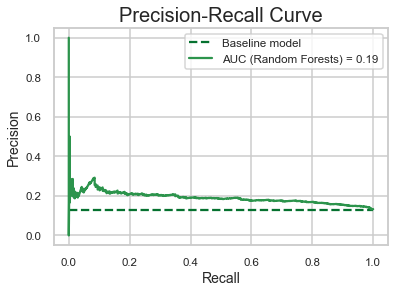

In [281]:
# random forest
rf = RandomForestClassifier(n_estimators=200, max_depth=3, 
                            criterion="entropy", random_state=47
                           )
rf.fit(X_train, y_train.values.ravel())
y_pred = rf.predict(X_test)

print("training size: {}".format(len(X_train)))
print("testing size: {}".format(len(X_test)))
accuracy = round(accuracy_score(y_test, y_pred), 2)
print("accuracy score: {}".format(accuracy))
print("hyperparameter(s): n_estimators=200, max_depth=3, criterion=entropy")
print("Confusion Matrix: {}".format(confusion_matrix(y_test, y_pred))) # TP, TN, FP, FN
print("Classification Report: {}".format(classification_report(y_test, y_pred)))
feature_importance = pd.DataFrame(rf.feature_importances_, index=X_train.columns, columns=['importance']).sort_values('importance', ascending=False)
print("feature importance: {}".format(feature_importance))

# plot precision recall curve
probs_rf = rf.predict_proba(X_test)[:, 1]
baseline_model = len(y_test[y_test.adopted==1]) / len(y_test)

precision_rf, recall_rf, _ = precision_recall_curve(y_test, probs_rf)
auc_rf = auc(recall_rf, precision_rf)

plt.plot([0, 1], [baseline_model, baseline_model], linestyle='--', label='Baseline model')
plt.plot(recall_rf, precision_rf, label=f'AUC (Random Forests) = {auc_rf:.2f}')
plt.title('Precision-Recall Curve', size=20)
plt.xlabel('Recall', size=14)
plt.ylabel('Precision', size=14)
plt.legend()

We can see that `usage_lifespan` is very important in predicting whether the users will become adopted users or not. This tells us that the longer the users have been using the app, the more likely they will adapt.